# SEIR Model for the Spread of Ebola in Western Africa

In this notebook, we present the performance of Transformed Iterative Mondrian Forests on data generated from a model for the spread of Ebola, presented in [[1]][R1]. This notebook is based on the [Active Subspaces Repo](https://github.com/paulcon/as-data-sets/blob/master/Ebola/Ebola.ipynb).

### Introduction

The recent Ebola outbreak in Western Africa has been the deadliest Ebola outbreak to date and has drawn international attention and support to the region. Important questions to consider are which countries should recieve additional aid and what aspects of the outbreak should the aid address. Some distinct characteristics of Ebola are its ability to remain infectious after the death of a host (especially problematic considering local burial rituals involve ample contact with the bodies of the dead) and the effects of hospitalization (hospital workers can be infected through contact with patients). In this notebook, we discuss an SEIR model that accounts for these aspects of Ebola and use _active subspaces_ to explore the global sensitivity of the model to its parameters.

### The Ebola Model

The model we employ is a modified SEIR model with the following assumptions: stochastic effects are negligible; births and non-ebola deaths are negligible; an individual can be removed and infectious (not properly buried), removed and non-infectious (properly buried), or removed and recovered; recovered individuals do not turn susceptible again; hospitalized individuals can spread the disease; deaths in hospitals are properly burried; and hospitalization increases chances of recovery. Under these assumptions, the equations governing our model are:

$$
\begin{align}
\frac{dS}{dt} &= -\beta_1SI - \beta_2SR_I - \beta_3SH,\\
\frac{dE}{dt} &= \beta_1SI + \beta_2SR_I + \beta_3SH - \delta E,\\
\frac{dI}{dt} &= \delta E - \gamma_1I - \psi I,\\
\frac{dH}{dt} &= \psi I - \gamma_2H,\\
\frac{dR_I}{dt} &= \rho_1\gamma_1I - \omega R_I,\\
\frac{dR_B}{dt} &= \omega R_I + \rho_2\gamma_2H,\\
\frac{dR_R}{dt} &= (1-\rho_1)\gamma_1I + (1-\rho_2)\gamma_2H,
\end{align}
$$

where $S$ represents the fraction of the population that is susceptible to infection, $E$ is the exposed population (infected but asymptomatic), $I$ is the infected fraction, $H$ is the hospitalized fraction, $R_I$ is the infectious dead (not properly buried), $R_B$ is the non-infectious dead (properly buried), and $R_R$ is the recovered population.

The basic reproduction number (a metric measuring how many new cases of disease each current case causes) can be found to be

$$
R_0 = \frac{\beta_1 + \frac{\beta_2\rho_1\gamma_1}{\omega} + \frac{\beta_3}{\gamma_2}\psi}{\gamma_1 + \psi}.
$$

The parameters are fit using data for the countries of Liberia and Sierra Leone, the results of which are summarized in the table below ($\delta$ is assumed to be $\frac 1 9$ in each case, a number taken from other sources).

Parameter | Liberia | Sierra Leone
:--------:|:-------:|:---------:
$\beta_1$|.376|.251
$\beta_2$|.135|.395
$\beta_3$|.163|.079
$\gamma_1$|.0542|.051
$\gamma_2$|.174|.0833
$\psi$|.5|.442
$\rho_1$|.98|.76
$\rho_2$|.88|.74
$\omega$|.325|.370

This results in basic reproduction numbers of 1.563 for Liberia and 1.445 for Sierra Leone.

### Active Subspaces

Active subspaces is a method for quantifying the global sensitivity of a model's output to its input parameters. In our case, the output is $R_0(\mathbf x)$, where $\mathbf x\in R^8$ is a vector representing the 8 normalized parameters $R_0$ depends on. The method is based on the matrix

$$
\mathbf C = \int\nabla R_0(\mathbf x)\nabla R_0(\mathbf x)^T\rho(\mathbf x)\ d\mathbf x = \mathbf W\Lambda\mathbf W^T,
$$

where $\nabla R_0$ is the gradient of $R_0$ with respect to the normalized parameters, $\rho$ is a probability density on the parameters, and $\mathbf W\Lambda\mathbf W^T$ is the eigendecomposition of $\mathbf C$ (with the eigenvalues in descending order). The eigenpairs satisfy the relationship $\lambda_i = \int(\nabla R_0^T\mathbf w_i)^2\rho\ d\mathbf x$. In words, this means the $i^{th}$ eigenvalue quantifies the average squared derivative of $R_0$ in the direction defined by the corresponding eigenvector; if some eigenvalues are small compared to the rest, $R_0$ will likely be relatively flat in the subspace defined by the span of the corresponding eigenvectors. Suppose $\lambda_{n+1} \ll \lambda_n$ for some $n < 7$. Then we can partition the eigendecomposition as

$$
\Lambda = \left[\begin{matrix}\Lambda_1 & \\ & \Lambda_2\end{matrix}\right],\ \mathbf W = \left[\begin{matrix}\mathbf W_1 & \mathbf W_2\end{matrix}\right],
$$

where $\Lambda_1$ contains the first $n$ eigenvalues and $\mathbf W_1$ the corresponding eigenvectors. We define $\alpha\in R^8$ as $\alpha = \alpha(n) = \sum_{j=1}^n\lambda_j\mathbf w_j^2$, where the exponent is elementwise. We call the components of $\alpha$ _activity scores_; a larger score for a parameter indicates relative sensitivity compared to the others.

For the following analysis, we use the following distributions ($\rho = $ U(min, max)) for the parameters.

Parameter | Liberia | Sierra Leone
:--------:|:-------:|:---------:
$\beta_1$|U(.1, .4)|U(.1, .4)
$\beta_2$|U(.1, .4)|U(.1, .4)
$\beta_3$|U(.05, .2)|U(.05, .2)
$\rho_1$|U(.41, 1)|U(.41, 1)
$\gamma_1$|U(.0276, .1702)|U(.0275, .1569)
$\gamma_2$|U(.081, .21)|U(.1236, .384)
$\omega$|U(.25, .5)|U(.25, .5)
$\psi$|U(.0833, .7)|U(.0833, .7)

### References:

[[1]][R1] P. Diaz, P. Constantine, K. Kalmbach, E. Jones, and S. Pankavich. _A Modified SEIR Model for the Spread of Ebola in Western Africa and Metrics for Resource Allocation_. arXiv:1603.04955, 2016

[[2]][R2] P.G. Constantine, E. Dow, and Q. Wang. _Active subspaces in theory and practice: applications to kriging surfaces_. SIAM J. Sci. Comput., 36(4), A1500–A1524, 2014

[R1]: http://arxiv.org/abs/1603.04955
[R2]: http://dx.doi.org/10.1137/130916138

<br>

We start by generating the data from the model.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from quadrature import gauss_legendre

First we set up functions returning $R_0$ and its gradient with respect to unnormalized parameters.

In [2]:
#Liberian lower and upper parameter bounds
lb_L = np.array([.1, .1, .05, .41, .0276, .081, .25, .0833])
ub_L = np.array([.4, .4, .2, 1, .1702, .21, .5, .7])

#basic reproduction number
def R0(x):
    b1 = x[:,0]; b2 = x[:,1]; b3 = x[:,2]; r1 = x[:,3]
    g1 = x[:,4]; g2 = x[:,5]; om = x[:,6]; p = x[:,7]
    
    return (b1 + b2*r1*g1/om + b3*p/g2)/(g1 + p)

#reproduction number gradient with respect to UNnormalized parameters
def R0_grad(x):
    b1 = x[:,0]; b2 = x[:,1]; b3 = x[:,2]; r1 = x[:,3]
    g1 = x[:,4]; g2 = x[:,5]; om = x[:,6]; p = x[:,7]
    
    dRdb1 = (1./(g1 + p))[:,None]
    dRdb2 = (r1*g1/om/(g1 + p))[:,None]
    dRdb3 = (p/g2/(g1 + p))[:,None]
    dRdr1 = (b2*g1/om/(g1 + p))[:,None]
    dRdg1 = (b2*r1/om/(g1 + p) - R0(x)/(g1 + p))[:,None]
    dRdg2 = (-b3*p/g2**2/(g1 + p))[:,None]
    dRdom = (-b2*r1*g1/om**2/(g1 + p))[:,None]
    dRdp = (b3/g2/(g1 + p) - R0(x)/(g1 + p))[:,None]
    
    return np.hstack((dRdb1, dRdb2, dRdb3, dRdr1, dRdg1, dRdg2, dRdom, dRdp))

#Integrand for C
def subspace_integrand(df):
    df = df.reshape((8, 1))
    return df.dot(df.T)*2**-8

$\mathbf C$ is approximated with Gauss-Legendre quadrature with 8 points in each of the 8 dimensions of the parameter space. Gradients with respect to normalized parameters must be computed according to the chain rule: if $p$ is an unnormalized parameter and $x$ is its normalized version, then $\frac{\partial R_0}{\partial x} = \frac{\partial R_0}{\partial p}\frac{\partial p}{\partial x}$, and $p = l + \frac{u-l}{2}(x+1)\Rightarrow\frac{\partial p}{\partial x} = \frac{u - l}{2}$, where $u$ and $l$ are the upper and lower bounds on the parameter. This takes about 15 minutes on a standard workstation.

In [3]:
#gauss-legendre quadrature points/weights
xx, w = gauss_legendre([8, 8, 8, 8, 8, 8, 8, 8])

#un-normalized inputs for Liberia (S) and Sierra Leone (S)
x_L = lb_L + (ub_L - lb_L)/2.*(xx + 1)

#output and gradient values
R_L = R0(x_L)
dR_L = R0_grad(x_L)

#Gradients with respect to noramlized inputs according to the chain rule
dR_L *= (ub_L - lb_L)/2

#Compute C for Liberia
integrands = []
for i in range(dR_L.shape[0]):
    integrands.append(subspace_integrand(dR_L[i])*w[i])
integrands = np.array(integrands)
C_L = integrands.sum(axis=0)

#Sierra Leone bounds
lb_S = np.array([.1, .1, .05, .41, .0275, .1236, .25, .0833])
ub_S = np.array([.4, .4, .2, 1, .1569, .384, .5, .7])

x_S = lb_S + (ub_S - lb_S)/2.*(xx + 1)

R_S = R0(x_S)
dR_S = R0_grad(x_S)
dR_S *= (ub_S - lb_S)/2

#Compute C for Sierra Leone
integrands = []
for i in range(dR_S.shape[0]):
    integrands.append(subspace_integrand(dR_S[i])*w[i])
integrands = np.array(integrands)
C_S = integrands.sum(axis=0)

Now that we have the $\mathbf C$'s, we compute their eigendecompositions.

In [4]:
def sorted_eigh(C):
    """Compute eigenpairs and sort.
    
    Parameters
    ----------
    C : ndarray
        matrix whose eigenpairs you want
        
    Returns
    -------
    e : ndarray
        vector of sorted eigenvalues
    W : ndarray
        orthogonal matrix of corresponding eigenvectors
    
    Notes
    -----
    Eigenvectors are unique up to a sign. We make the choice to normalize the
    eigenvectors so that the first component of each eigenvector is positive.
    This normalization is very helpful for the bootstrapping. 
    """
    e, W = np.linalg.eigh(C)
    e = abs(e)
    ind = np.argsort(e)
    e = e[ind[::-1]]
    W = W[:,ind[::-1]]
    s = np.sign(W[0,:])
    s[s==0] = 1
    W = W*s
    return e.reshape((e.size,1)), W

#Sorted eigendecompositions for the C matrices
e_L, W_L = sorted_eigh(C_L)

Now we split the data into training and testing sets. The rest is similar to the [simulation notebook](./Simulations.ipynb).

In [5]:
from sklearn.model_selection import train_test_split

# subsample 2000 points from xx
np.random.seed(0)
subsample = np.random.choice(np.arange(xx.shape[0]), 4000, replace=False)
xx = xx[subsample]
R_L = R_L[subsample]
x_train, x_test, y_train, y_test = train_test_split(xx, R_L, test_size=0.2, random_state=42)

In [6]:
from utils import *

dim_in = 8
active = 2
tries = 10
lifetime = 5
step_size = 0.5
n_estimators = 10
sample_range = [100, 200, 400, 800, 1600, 3200]

np.random.seed(0)

true_H = C_L
true_H/two_one_norm(true_H)

array([[ 0.5742618 ,  0.09775744,  0.51721178,  0.06817599, -0.33884982,
        -0.44261393, -0.05876424, -0.95255451],
       [ 0.09775744,  0.02231731,  0.09058294,  0.01470579, -0.05133639,
        -0.0775181 , -0.01394832, -0.14466792],
       [ 0.51721178,  0.09058294,  0.69899327,  0.0631725 , -0.27239695,
        -0.64274711, -0.05445148, -0.63960626],
       [ 0.06817599,  0.01470579,  0.0631725 ,  0.01148651, -0.03512529,
        -0.05406108, -0.01029406, -0.10235781],
       [-0.33884982, -0.05133639, -0.27239695, -0.03512529,  0.25241913,
         0.26557124,  0.02921207,  0.69713015],
       [-0.44261393, -0.0775181 , -0.64274711, -0.05406108,  0.26557124,
         0.70531094,  0.0465979 ,  0.50354178],
       [-0.05876424, -0.01394832, -0.05445148, -0.01029406,  0.02921207,
         0.0465979 ,  0.01012545,  0.09053335],
       [-0.95255451, -0.14466792, -0.63960626, -0.10235781,  0.69713015,
         0.50354178,  0.09053335,  2.33085947]])

Training the Mondrian Forests:


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [11:14<00:00, 67.43s/it]


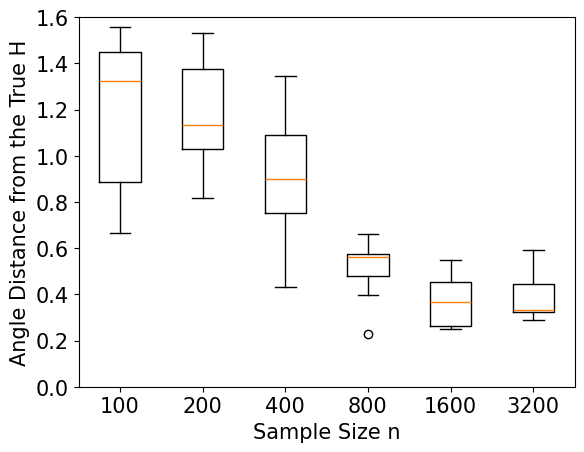

In [7]:
simulation = Simulation(dim_in, active, n_estimators, tries, lifetime, step_size, sample_range, x_train, x_test, y_train, y_test, true_H)

simulation.train()
plt.savefig("ebola/dist_to_true_H_1.png")

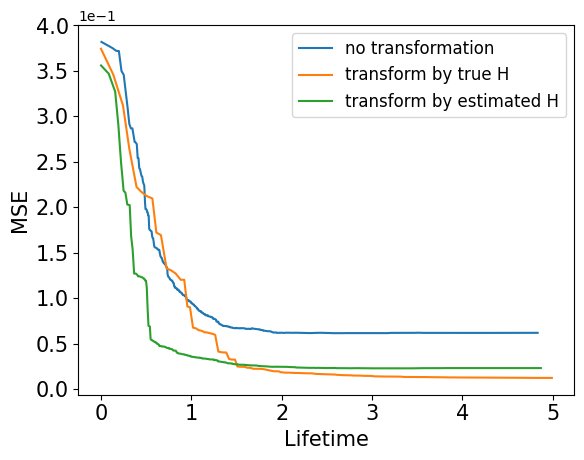

In [8]:
simulation.evaluation_comparison()
plt.savefig("ebola/evaluation_comparison_1.png")

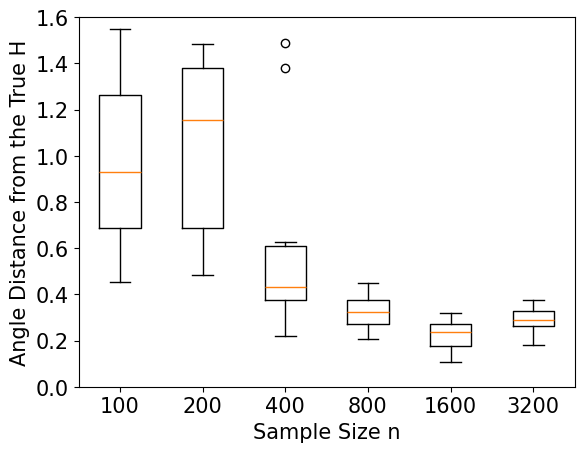

In [9]:
simulation.reiterate()
plt.savefig("ebola/dist_to_true_H_reiterate_1.png")

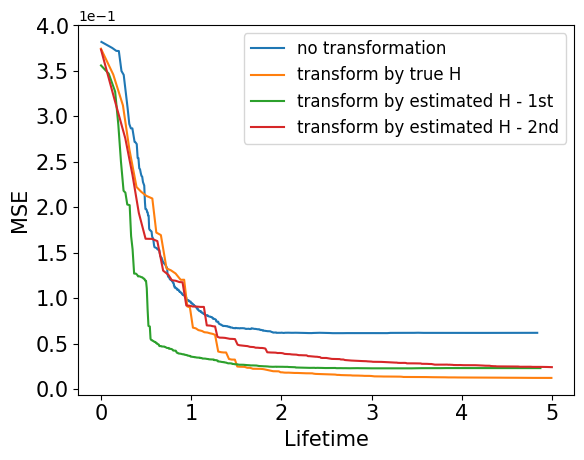

In [10]:
simulation.evaluation_comparison_reiterate()
plt.savefig("ebola/evaluation_comparison_reiterate_1.png")

In [11]:
true_H = C_S
true_H/two_one_norm(true_H)

array([[ 0.63905809,  0.10267438,  0.33701665,  0.07160506, -0.27378271,
        -0.35395299, -0.06171992, -1.23190826],
       [ 0.10267438,  0.02183686,  0.0555646 ,  0.0143892 , -0.03885415,
        -0.05835692, -0.01364804, -0.18392158],
       [ 0.33701665,  0.0555646 ,  0.27542413,  0.03875072, -0.11994816,
        -0.31959764, -0.03340115, -0.49107095],
       [ 0.07160506,  0.0143892 ,  0.03875072,  0.01123923, -0.02644067,
        -0.04069809, -0.01007244, -0.12975335],
       [-0.27378271, -0.03885415, -0.11994816, -0.02644067,  0.16146359,
         0.14286418,  0.02175859,  0.6864197 ],
       [-0.35395299, -0.05835692, -0.31959764, -0.04069809,  0.14286418,
         0.45179509,  0.03507969,  0.49171459],
       [-0.06171992, -0.01364804, -0.03340115, -0.01007244,  0.02175859,
         0.03507969,  0.00990746,  0.11417846],
       [-1.23190826, -0.18392158, -0.49107095, -0.12975335,  0.6864197 ,
         0.49171459,  0.11417846,  3.23039413]])

In [12]:
R_S = R_S[subsample]
x_train, x_test, y_train, y_test = train_test_split(xx, R_S, test_size=0.2, random_state=42)

simulation = Simulation(dim_in, active, n_estimators, tries, lifetime, step_size, sample_range, x_train, x_test, y_train, y_test, true_H)

Training the Mondrian Forests:


100%|██████████| 10/10 [11:00<00:00, 66.05s/it]


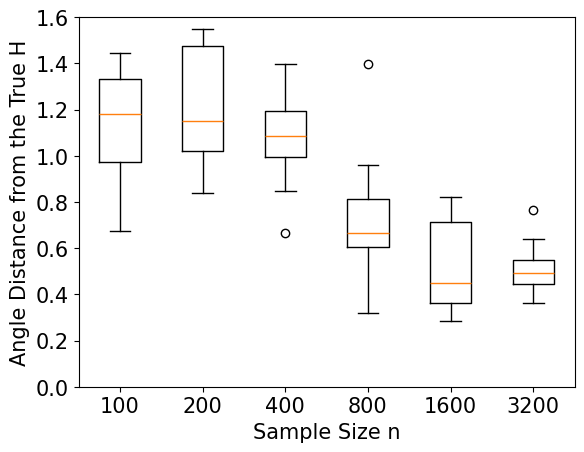

In [13]:
simulation.train()
plt.savefig("ebola/dist_to_true_H_2.png")

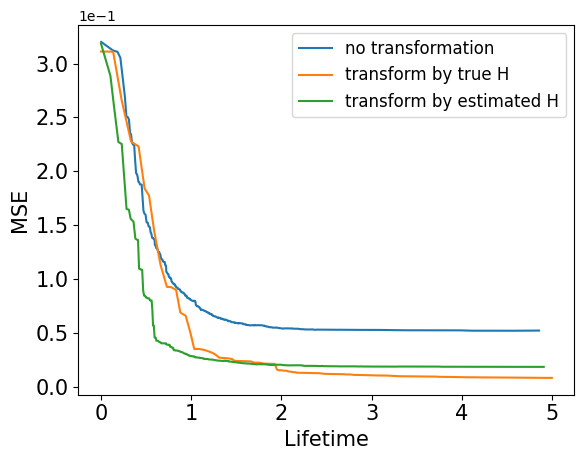

In [14]:
simulation.evaluation_comparison()
plt.savefig("ebola/evaluation_comparison_2.png")

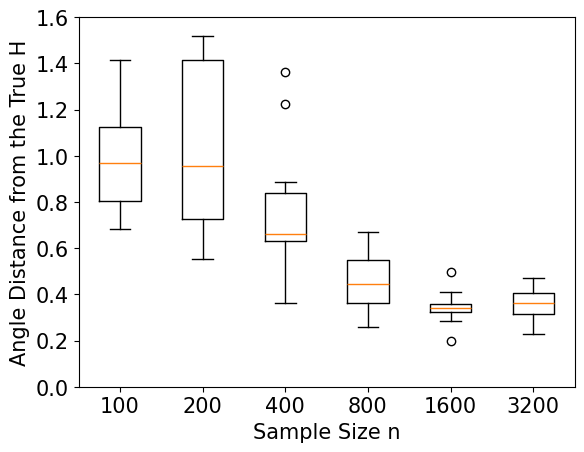

In [15]:
simulation.reiterate()
plt.savefig("ebola/dist_to_true_H_reiterate_2.png")

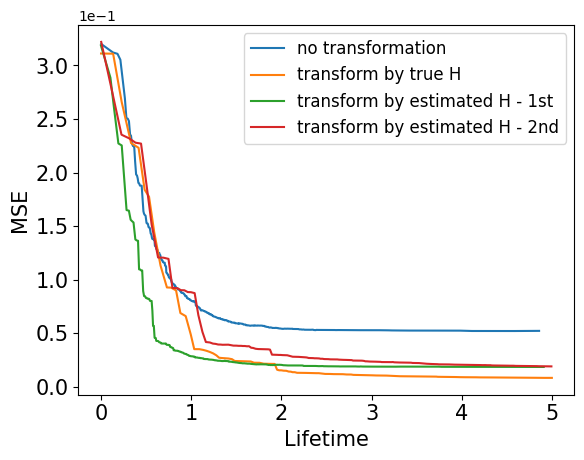

In [16]:
simulation.evaluation_comparison_reiterate()
plt.savefig("ebola/evaluation_comparison_reiterate_2.png")